In [18]:
from transformer_lens import HookedTransformer  # type: ignore

In [19]:
model = HookedTransformer.from_pretrained("gpt2")

Loaded pretrained model gpt2 into HookedTransformer


In [20]:
out, cache = model.run_with_cache("Hello, how are you?")
out

tensor([[[ 7.5261, 11.1214,  7.8919,  ..., -3.1299, -3.3873,  8.5934],
         [12.6877,  5.6732,  1.4202,  ..., -0.1857, -0.5829,  5.4394],
         [ 7.0628,  2.4974,  1.9990,  ...,  0.3997, -1.0289,  6.9055],
         ...,
         [ 6.5808,  3.6308,  1.8215,  ...,  0.2447, -2.9500,  4.3658],
         [12.5154,  6.8293,  3.7944,  ..., -1.0004, -1.5481,  5.7356],
         [ 7.2098,  5.7401,  5.0575,  ..., -2.3576, -2.5064,  9.5046]]],
       device='mps:0', grad_fn=<ViewBackward0>)

In [21]:
model.cfg.d_model

768

In [4]:
cache["blocks.6.hook_resid_post"].norm(dim=-1)

tensor([[3084.0552,  104.4712,   93.4986,   88.1998,   94.6973,   91.5668,
           95.4919]], device='mps:0')

In [5]:
model.blocks[6]

TransformerBlock(
  (ln1): LayerNormPre(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (ln2): LayerNormPre(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (attn): Attention(
    (hook_k): HookPoint()
    (hook_q): HookPoint()
    (hook_v): HookPoint()
    (hook_z): HookPoint()
    (hook_attn_scores): HookPoint()
    (hook_pattern): HookPoint()
    (hook_result): HookPoint()
  )
  (mlp): MLP(
    (hook_pre): HookPoint()
    (hook_post): HookPoint()
  )
  (hook_attn_in): HookPoint()
  (hook_q_input): HookPoint()
  (hook_k_input): HookPoint()
  (hook_v_input): HookPoint()
  (hook_mlp_in): HookPoint()
  (hook_attn_out): HookPoint()
  (hook_mlp_out): HookPoint()
  (hook_resid_pre): HookPoint()
  (hook_resid_mid): HookPoint()
  (hook_resid_post): HookPoint()
)

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from generate_activations import ActivationAccumulator

# N = number of sequences
# S = sequence length
# D = d_model



def plot_histogram(norms_N: np.ndarray, title: str):
    plt.figure(figsize=(10, 6))
    plt.hist(norms_N, bins=300, density=True, alpha=0.75, range=(norms_N.min(), norms_N.max()))
    plt.xlabel("Norm")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.2)
    plt.yscale('log')  # Add log scale for y-axis
    plt.title(title)
    plt.show()
    plt.close()


def plot_histogram_bounded(norms_N: np.ndarray, title: str):
    plt.figure(figsize=(10, 6))
    plt.hist(norms_N, bins=100, density=True, alpha=0.75, range=(30, 120))
    plt.xlabel("Norm")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.2)
    plt.title(title)
    plt.show()
    plt.close()


def get_norms(activation_accumulator: ActivationAccumulator):
    activations_NSD = activation_accumulator.get_activations()
    N, S, D = activations_NSD.shape
    activations_ND = np.reshape(activations_NSD, (N * S, D))

    norms_N = np.linalg.norm(activations_ND, axis=1)

    mean_activation_D = activations_ND.mean(axis=0)
    activations_ND_shift = activations_ND - mean_activation_D
    norms_centered_N = np.linalg.norm(activations_ND_shift, axis=1)

    return norms_N, norms_centered_N


In [71]:
from pathlib import Path

# tinystories
ts_resid_post_path = Path("data") / "roneneldan/TinyStories" / "blocks.6.hook_resid_post" / "activations9.npy"
ts_resid_post_acc = ActivationAccumulator.load(ts_resid_post_path)

ts_ln2_path = Path("data") / "roneneldan/TinyStories" / "blocks.6.ln2.hook_normalized" / "activations9.npy"
ts_ln2_acc = ActivationAccumulator.load(ts_ln2_path)

ts_lns_path = Path("data") / "roneneldan/TinyStories" / "blocks.6.ln2.hook_scale" / "activations9.npy"
ts_lns_acc = ActivationAccumulator.load(ts_lns_path)


allocating space for 1000 sequences of activations
Loaded 999 sequences of activations
allocating space for 5461 sequences of activations
Loaded 1279 sequences of activations
allocating space for 5461 sequences of activations
Loaded 1279 sequences of activations


In [73]:
activations_NSD_ = ts_ln2_acc.get_activations()
N, S, D = activations_NSD_.shape
activations_ND_ = np.reshape(activations_NSD_, (N * S, D))
activations_ND_.mean(axis=0)

array([-4.74661514e-02, -5.52795380e-02, -3.47713143e-01, -1.37044013e-01,
       -2.23720029e-01, -1.51242360e-01,  4.98236865e-01,  1.76714852e-01,
        5.81196286e-02, -2.97568161e-02,  8.80805179e-02,  6.95543811e-02,
       -2.32697770e-01, -2.10933179e-01,  7.51010105e-02,  1.51567131e-01,
        5.82788698e-02,  2.36606434e-01, -9.18041244e-02,  2.35757291e-01,
       -2.65096486e-01, -2.66599059e-01, -2.21127167e-01,  9.79503170e-02,
        2.28021115e-01,  6.86300024e-02,  1.34167215e-02, -7.47279497e-03,
       -9.56141874e-02,  1.59272268e-01, -1.86542183e-01, -4.03831124e-01,
        1.08123600e-01, -8.26770216e-02,  2.34255288e-02,  1.82128716e-02,
        2.49716938e-01,  1.34248003e-01, -1.14334978e-01,  1.72418624e-01,
        2.60775089e-01,  9.09975767e-02, -2.58001462e-02, -8.67809653e-02,
       -1.83712989e-01, -2.40733802e-01, -3.21933627e-02,  6.33403584e-02,
        2.18651211e-03,  1.88621089e-01, -2.46269591e-02, -8.31817463e-02,
        1.12188734e-01, -

110.342155
261.3502


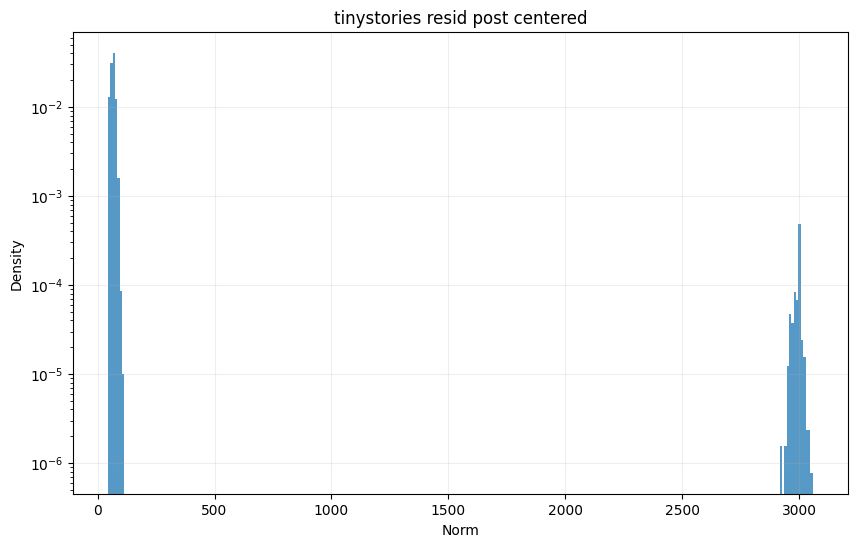

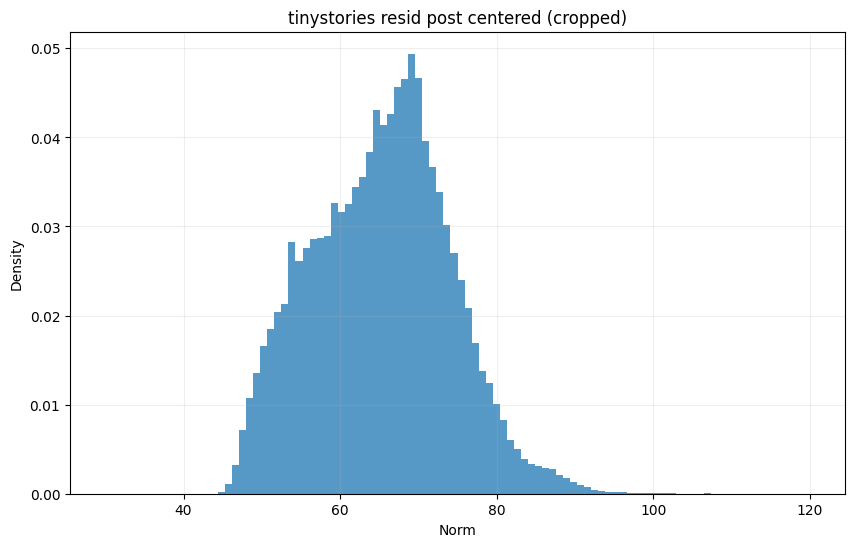

In [75]:
ts_resid_post_norms_N, ts_resid_post_norms_centered_N = get_norms(ts_resid_post_acc)
mean_ts_resid_post_norms_N = ts_resid_post_norms_N.mean()
std_ts_resid_post_norms_N = ts_resid_post_norms_N.std()
print(mean_ts_resid_post_norms_N)
print(std_ts_resid_post_norms_N)


# plot_histogram(ts_resid_post_norms_N, "tinystories resid post")
plot_histogram(ts_resid_post_norms_centered_N, "tinystories resid post centered")
plot_histogram_bounded(ts_resid_post_norms_centered_N, "tinystories resid post centered (cropped)")

# ts_ln2_norms_N, ts_ln2_norms_centered_N = get_norms(ts_ln2_acc)
# plot_histogram(ts_ln2_norms_N, "tinystories ln2")
# plot_histogram(ts_ln2_norms_centered_N, "tinystories ln2 centered")

# ts_lns_norms_N, ts_lns_norms_centered_N = get_norms(ts_lns_acc)
# plot_histogram(ts_lns_norms_N, "tinystories lns")
# plot_histogram(ts_lns_norms_centered_N, "tinystories lns centered")



In [48]:
# common_corpus
cc_resid_post_path = Path("data") / "PleIAs/common_corpus" / "blocks.6.hook_resid_post" / "activations139.npy"
cc_resid_post_acc = ActivationAccumulator.load(cc_resid_post_path)

cc_ln2_path = Path("data") / "PleIAs/common_corpus" / "blocks.6.ln2.hook_normalized" / "activations9.npy"
cc_ln2_acc = ActivationAccumulator.load(cc_ln2_path)

allocating space for 1000 sequences of activations
Loaded 999 sequences of activations
allocating space for 5461 sequences of activations
Loaded 1279 sequences of activations


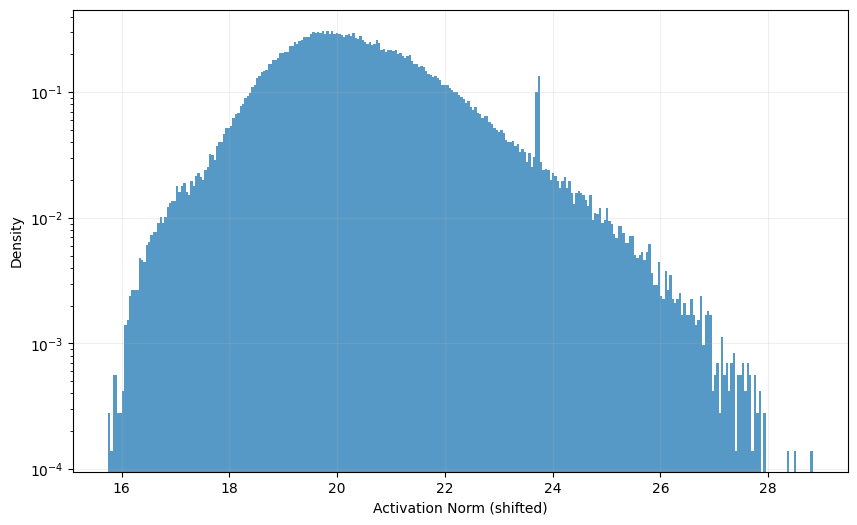

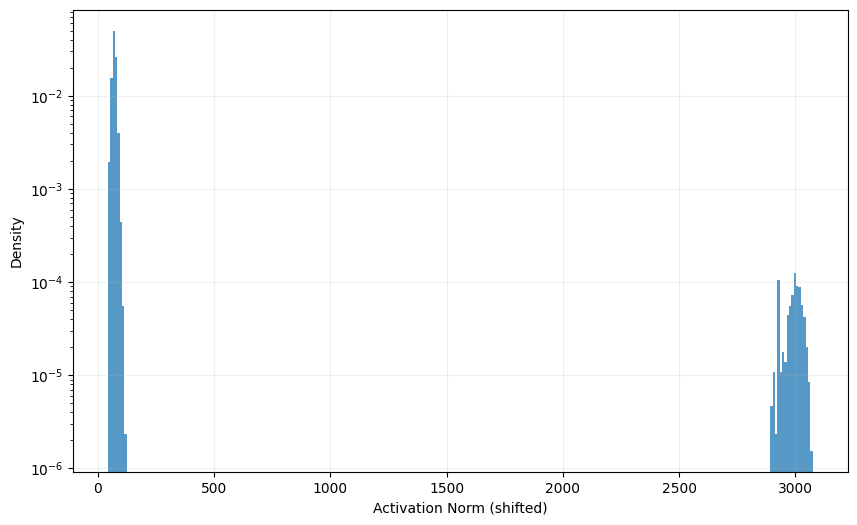

In [49]:
plot_histogram(get_norms(cc_ln2_acc))
plot_histogram(get_norms(cc_resid_post_acc))

In [31]:
# # overwrite huge file with smaller one
# def truncate_activations(acc: ActivationAccumulator, clip_size: int, path: Path):
#     assert acc._index >= clip_size, f"Index {acc._index} is not greater than clip size {clip_size}"
#     print(f"Truncating {path} from {acc._index} to {clip_size}")
#     acc._activations_NSD = acc._activations_NSD[:clip_size]
#     acc._index = clip_size
#     acc.save(path)

# truncate_activations(ts_acc, 1_000, ts_path)
# truncate_activations(cc_acc, 1_000, cc_path)

Truncating data/roneneldan/TinyStories/activations9.npy from 1000 to 1000
Truncating data/PleIAs/common_corpus/activations139.npy from 17919 to 1000
